# Prérequis

Ce notebook requiert les modules matplotlib, seaborn, plotly, ainsi que le module imgtools qui regroupe des fonctions nous avons crées pour ce projet.  
Le notebook utilise également le module 'tqdm' (https://github.com/tqdm/tqdm#readme). Si vous ne souhaitez pas le télécharger, laisser la valeur False ci-dessous, sinon la passer à True.

In [1]:
with_tqdm = True

# Initialisation

## Imports

In [2]:
# Modules usuels
import pandas as pd
import numpy as np
import random
import pickle
import math as m
import string
import warnings
from collections import defaultdict

# Modules graphiques
import matplotlib.pyplot as plt
import plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
import plotly.graph_objects as go
import seaborn as sns
import cufflinks as cf

# Modules de traitement du texte
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Modules additionnels
import imgtools as imt
if imt.version != 3:
    raise ImportError("Votre version de imgtools n'est pas la bonne !")
if with_tqdm:
    from tqdm import tqdm
else:
    def tqdm(it):
        return it

## Téléchargements

In [3]:
# NTLK corpuses
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\basti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Options

In [4]:
# Exceptions
warnings.simplefilter(action='ignore', category=FutureWarning) # pour sns.distplot

# Graphics
sns.set_style()
py.offline.init_notebook_mode(connected=False)
cf.go_offline(connected=False)

## Constantes

In [5]:
# NTLK corpuses
STOPWORDS = set(nltk.corpus.stopwords.words('french'))

# Relative paths
PATH_DATAFRAME = "./trainset.csv"
PATH_TRAIN = "../images/image_train"
PATH_TEST = "../images/image_test"

# Extraction des données

In [6]:
# Chargement du jeu de données d'entrainement
df = pd.read_csv(PATH_DATAFRAME).set_index('productid')
display(df.head())

designation  \
productid                                                       
3804725264  Olivia: Personalisiertes Notizbuch / 150 Seite...   
436067568   Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
201115110   Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
50418756    Peluche Donald - Europe - Disneyland 2000 (Mar...   
278535884                                La Guerre Des Tuques   

                                                  description     imageid  \
productid                                                                   
3804725264                                                NaN  1263597046   
436067568                                                 NaN  1008141237   
201115110   PILOT STYLE Touch Pen de marque Speedlink est ...   938777978   
50418756                                                  NaN   457047496   
278535884   Luc a des id&eacute;es de grandeur. Il veut or...  1077757786   

            target  
productid           
3804725264       0  
436067568        1  
201115110        2  
50418756         3  
278535884        4

In [7]:
# Chargement de la table de correspondance des labels
lab_enc = pd.read_csv('labels_encoding.csv')
display(lab_enc)

prdtypecode  target                           prdtype
0            10       0                     livres_adulte
1          2280       1                         magazines
2            50       2           accessoires_jeux_videos
3          1280       3                    jouets_enfance
4          2705       4               livres_et_illustres
5          2522       5                         papeterie
6          2582       6           mobilier_jardin_cuisine
7          1560       7       mobilier_interieur_litterie
8          1281       8                      jeux_societe
9          1920       9             accessoires_interieur
10         2403      10                   livres_jeunesse
11         1140      11                      goodies_geek
12         2583      12                       piscine_spa
13         1180      13                figurines_wargames
14         1300      14  modeles_reduits_ou_telecommandes
15         2462      15                         jeux_geek
16         1160      16                    cartes_a_jouer
17         2060      17              decoration_interieur
18           40      18                jeux_videos_import
19           60      19            jeux_et_consoles_retro
20         1320      20                    petite_enfance
21         1302      21                    jouets_enfants
22         2220      22          pour_animaux_domestiques
23         2905      23        jeux_videos_dematerialises
24         2585      24                  jardin_bricolage
25         1940      25                        nourriture
26         1301      26                  materiel_enfance

# Analyse des images

## Affichage de 5 images par classe

In [8]:
#with plt.rc_context({'figure.max_open_warning': 0}):
#
#    # Iterate through product codes
#    for label in tqdm(lab_enc['target']):
#
#        # Indexes matching label
#        idxs = list(df[df['target'] == label].index)
#
#        # Sample random specimens
#        idxs_rand = random.sample(idxs, 5)
#        
#        # Extract imageids
#        imageids = df.loc[idxs_rand, 'imageid']
#
#        # Titres
#        idx_lab = (lab_enc['target'] == label).index[0]
#        titles = "[{}] ".format(lab_enc.at[idx_lab, 'target'])
#        titles += lab_enc.at[idx_lab, 'prdtype']
#        titles = [titles]*5
#
#        # Load and display images
#        images = imt.load_id(PATH_TRAIN, imageids)
#        imt.disp_grid(images, 1, 5, titles=titles)

On constate déjà que même au sein d'une même classe, les images représentent des objets très divers.

## Images moyenne et variance par classe

### Calculs

In [9]:
compute_mean_images = False # EDIT to run (or not) /!\ REALLY LONG computation /!\
save_result = False # EDIT to run (or not) /!\ Overwrites previous savefile if it exists /!\


FILE_SAVE_MEAN = 'mean_images.pkl'
FILE_LOAD_MEAN = 'mean_images.pkl'


if compute_mean_images:
    
    # Create empty containers
    mean_images = dict()
    var_images = dict()
    
    # Iterate through product codes
    for label in tqdm(lab_enc['target']):

        # Imageids matching label
        idxs = list(df[df['target'] == label].index)
        imageids = df.loc[idxs, 'imageid']
        
        # Load images
        images = imt.load_id(PATH_TRAIN, imageids)
        
        # Compute mean
        mean_images[label] = imt.mean_img(images)
        
        # Compute var
        var_images[label] = imt.var_img(images, mean_images[label])

        
if save_result: 
    # Serialize in binary files   
    
    with open(FILE_SAVE_MEAN, 'wb') as savefile:
        pickle.dump(mean_images, savefile)
    
    with open(FILE_SAVE_VAR, 'wb') as savefile:
        pickle.dump(var_images, savefile)

### Chargement

In [10]:
FILE_SAVE_VAR = 'var_images.pkl'
FILE_LOAD_VAR = 'var_images.pkl'

# Load savefiles
with open(FILE_LOAD_MEAN, 'rb') as savefile:
    mean_images = pickle.load(savefile)
with open(FILE_LOAD_VAR, 'rb') as savefile:
    var_images = pickle.load(savefile)

### Images moyennes

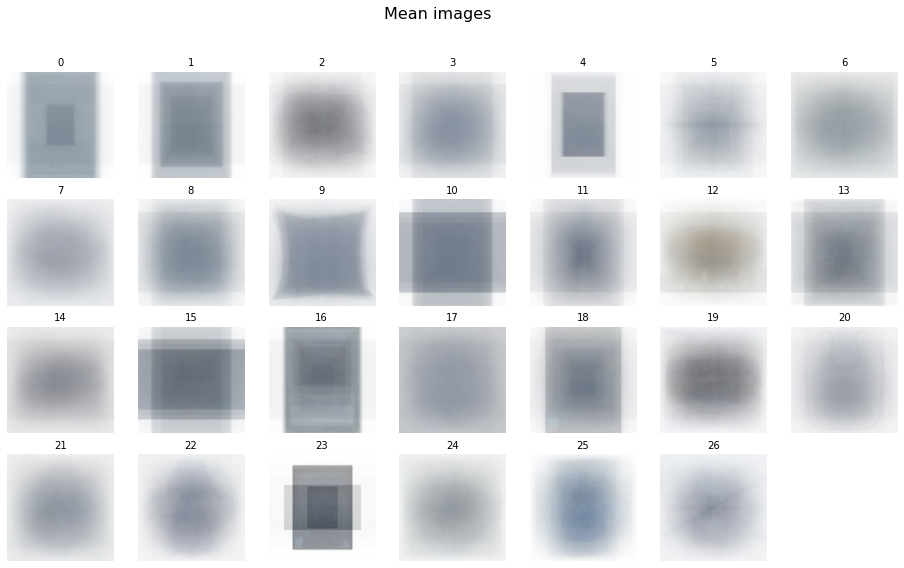

In [11]:
mean_images = list(mean_images.values())
lab_str = list(lab_enc['target'].astype('str'))
imt.disp_grid(mean_images, 4, 7, titles=lab_str, suptitle="Mean images (All channels)")

Pour plusieurs classes, la dispersion de la luminance (les nuances de gris) est telle qu'on observe un genre de bruit gaussien 2D centré (classes 6, 7, 21, 24, ...). Pour quelques classes cependant, on observe des formes plus géométriques, surtout rectangulaires (classes 0, 1, 4, 10, 13, 15, 16, 23, ...). On pourrait imaginer que les objets concernés soit plutôt rectangulaires, et placés soit en portrait soit en paysage sur les images. Cependant, il faut être prudent, car toutes images ont été préformattées en RGB 500x500 pixels, et cela a pu créer un effet de cadre/bandeau sur les images.

Les couleurs observées, à dominante gris-brun, indiquent que la répartition entre les trois couleurs RGB est sensiblement la même (sauf par exemple pour la classe 25 un peu plus de bleu, ou la classe 19 un peu plus de rouge). La couleur observée au sein de chaque image semble relativement homogène, ce qui peut indiquer une forte dispersion pour chaque couleur primaire RGB (ce qui fait que le mélange des trois couleurs est à peu près le même partout).
Observons sur chaque canal de couleur pour vérifier.

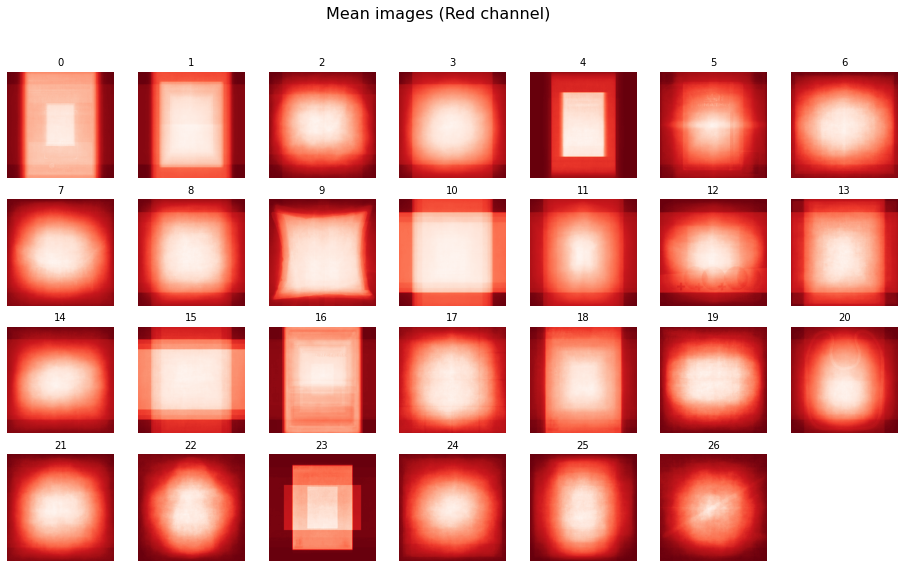

In [12]:
imt.disp_grid(mean_images, 4, 7, channel=0, cmap='Reds', titles=lab_str, suptitle="Mean images (Red channel)")

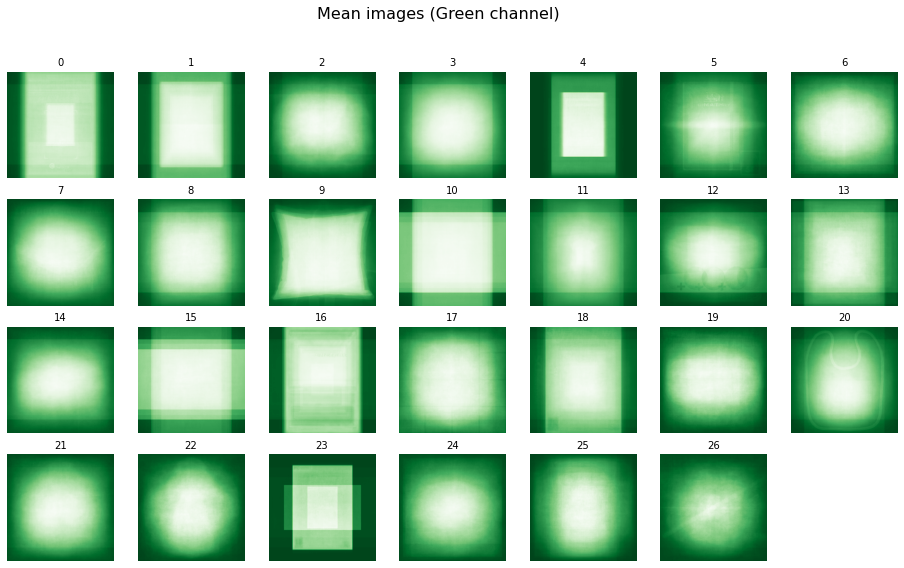

In [13]:
imt.disp_grid(mean_images, 4, 7, channel=1, cmap='Greens', titles=lab_str, suptitle="Mean images (Green channel)")

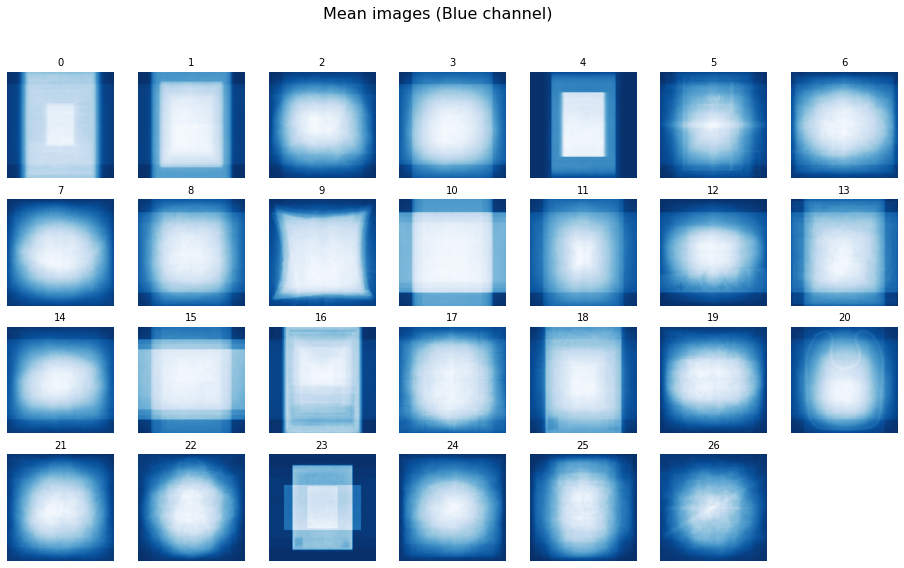

In [14]:
imt.disp_grid(mean_images, 4, 7, channel=2, cmap='Blues', titles=lab_str, suptitle="Mean images (Blue channel)")

On n'observe pas de différence sensible entre les canaux de couleur.  
La couleur dominante (parmi R, G, B) de l'image ne semble donc pas être un critère de classification pertinent.

### Images variance

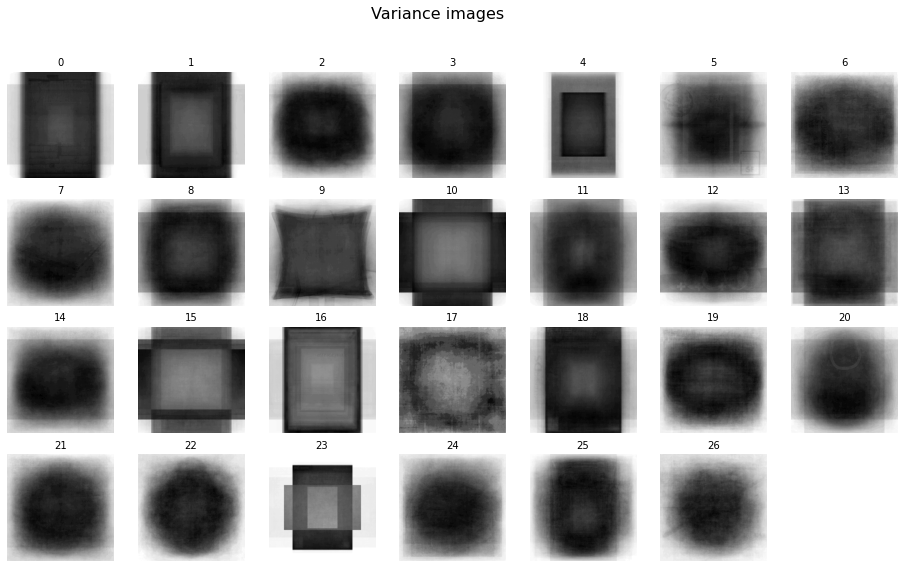

In [19]:
var_images_luminance = imt.grayscale(var_images)
imt.disp_grid(var_images_luminance, 4, 7, cmap='binary', titles=lab_str, suptitle="Variance images")

On observe ici la luminance de la variance pixel par pixel. Avec la colormap utilisée, plus on se rapproche du noir, plus la variance est élevée.  
Ce que l'on observe est similaire à ce que l'on voyait pour la moyenne, mais avec un contraste supérieur. Par exemple pour la classe 16 ('cartes_a_jouer), on voit mieux les différences d'échelle entre les cartes phototographiées.
Pour la classe 17 ('decoration_interieur'), on observe de la granulosité au centre de l'image, ce qui montre que les objets photographiés ont des formes et dimensions très différentes.  
De manière générale, on observe assez peu de variance sur les bords images, ce qui est assez naturel, car les objets sont au centre des images, et de plus les images ont été reformatées, ce qui a du rajouté du vide sur les bords.

## Conclusion sur la partie images

Nous avons envisagé d'autres visualisations :
1. Couleurs dominantes (déterminées par clustering) par classes
2. Distances intra-classes et inter-classes (avec une métrique simple, e.g. distance euclidienne)
3. Matrice de covariance des images moyennes des classes (pour évaluer la similarité par transformations linéaires)

Cependant, étant donné le temps dont nous disposions et les résultats déjà obtenus, nous avons estimés que cela ne nous avancerait pas davantage. La dispersion intra-classe est telle que nous n'aurions de toute manière pas obtenus de résultats suffisamments probants pour une classification avec des techniques de machine learning classiques.

**L'ampleur de la dispersion nous incite à nous orienter vers des méthodes de deep-learning pour le traitement des images.**